In [1]:
import funcs
import mrsobs

import itertools
import numpy as np
from astropy.io import fits
from scipy.stats import norm
from scipy.interpolate import interp1d
from scipy.ndimage import gaussian_filter1d

import matplotlib.pyplot as plt
import matplotlib.mlab as mlab
from mpl_toolkits.mplot3d import Axes3D
%matplotlib notebook

In [2]:
%autosave 30

Autosaving every 30 seconds


In [24]:
workDir  = '/Users/ioannisa/Desktop/python/miri_devel/'
d2cMapDir = workDir+'notebooks/distortionMaps/'
lvl1path = workDir+'CV3_data/LVL1/'

band   = '1A'
infile_PixelToPixelMap = 'NonLinearityCorrection_OutputParameters_CV3_MRS_RAD_14_Band{}.npy'.format(band)
infile_BestModel = 'NonLinearityCorrection_OutputParameters_BestModel_CV3_MRS_RAD_14_Band{}.npy'.format(band)

In [4]:
nl_coefficients_PixelToPixelMap = np.load(infile_PixelToPixelMap)
nl_coefficients_BestModel = np.load(infile_BestModel)

In [5]:
d2cMaps = funcs.load_obj('d2cMaps_band{}_tr90pc'.format(band),path=d2cMapDir)
sel = (d2cMaps['sliceMap'] > 100*int(band[0])) & (d2cMaps['sliceMap'] < 100*(int(band[0])+1) )

In [59]:
# The non-linearity correction is described by a n-th order polynomial, define the order here, as well as the integration ramp to be used
order = 4
analyze_ramp = 1

# define frames in ramp to skip
skip_first = 3
skip_last  = 1

In [46]:
filename = '/Users/ioannisa/Desktop/python/miri_devel/FM_data/LVL1/FM1T00012668/MIRFM1T00012668_1_495_SE_2011-07-06T17h08m40.fits' # mrsobs.MIRI_internal_calibration_source(lvl1path,band,campaign='CV3',output='filename').replace('_LVL2','')

image_hdu = fits.open(filename)
image_data = fits.getdata(filename)[:,:1024,:].astype('float')

In [47]:
image_shape = image_data.shape
nints       = image_hdu[0].header['NINT']
ngroups     = image_hdu[0].header['NGROUP']
nframes     = image_shape[0]
readout     = image_hdu[0].header['READOUT']
frame_delta_time = image_hdu[0].header['TFRAME']
print('Number of integrations: {}'.format(nints))
print('Number of groups/frames per integration: {}'.format(ngroups))
print('Total number of frames: {}'.format(nframes))
print('Readout: {}'.format(readout))
print('Time between samples: {} sec'.format(frame_delta_time))
print('LVL1 data shape: {}'.format(image_shape))

Number of integrations: 5
Number of groups/frames per integration: 20
Total number of frames: 100
Readout: FAST
Time between samples: 2.77504 sec
LVL1 data shape: (100, 1024, 1032)


In [48]:
image_hdu.close()

<IPython.core.display.Javascript object>


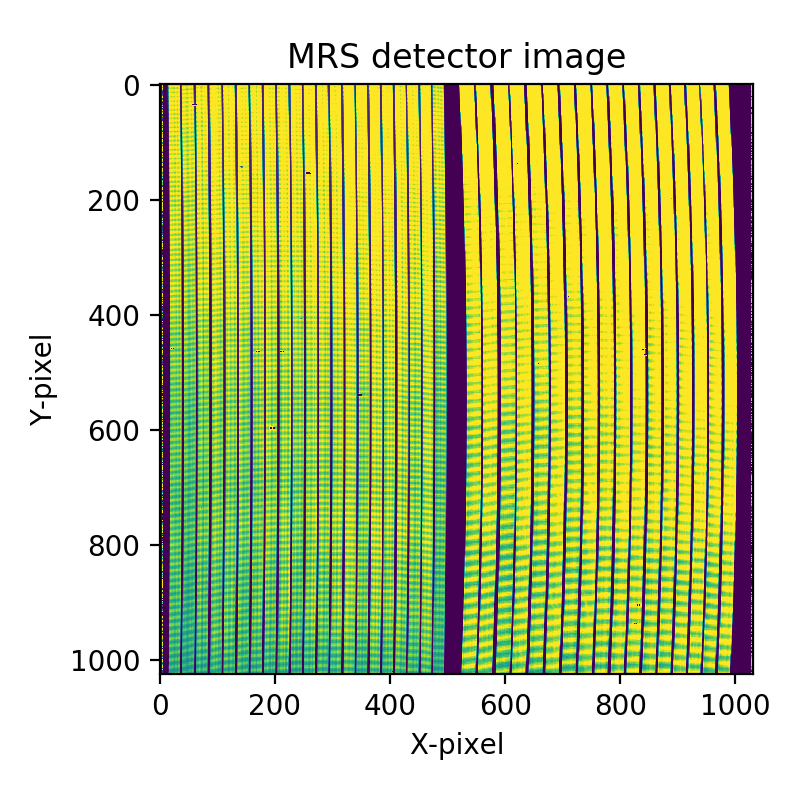

<IPython.core.display.Javascript object>


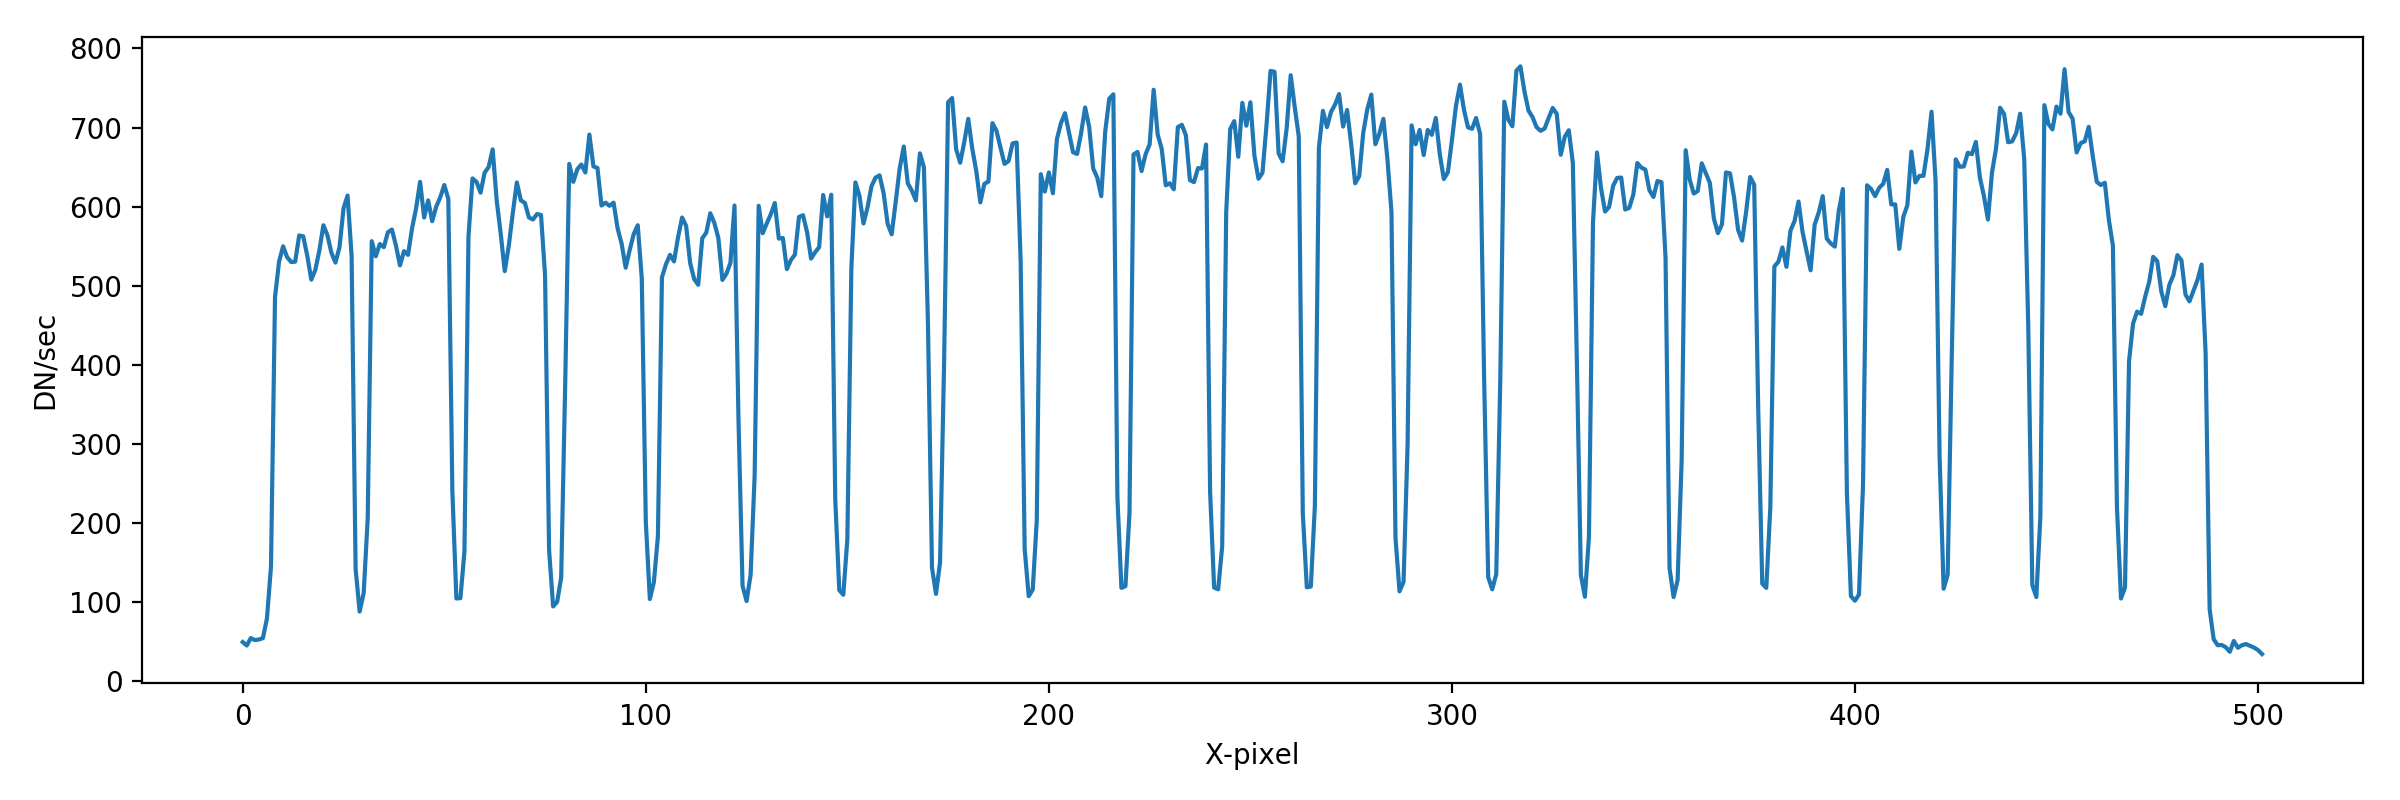

In [49]:
slope_img = (image_data[3,:,:]-image_data[2,:,:])/frame_delta_time
plt.figure(figsize=(4,4))
plt.imshow(slope_img,vmin=100,vmax=700)
plt.xlabel('X-pixel')
plt.ylabel('Y-pixel')
plt.title('MRS detector image')
plt.tight_layout()

row = 512
plt.figure(figsize=(12,4))
if band[0] in ['1','4']:
    plt.plot(slope_img[row,10:512])
elif band[0] in ['2','3']:
    plt.plot(slope_img[row,512:1026])
plt.xlabel('X-pixel')
plt.ylabel('DN/sec')
plt.tight_layout()

<IPython.core.display.Javascript object>


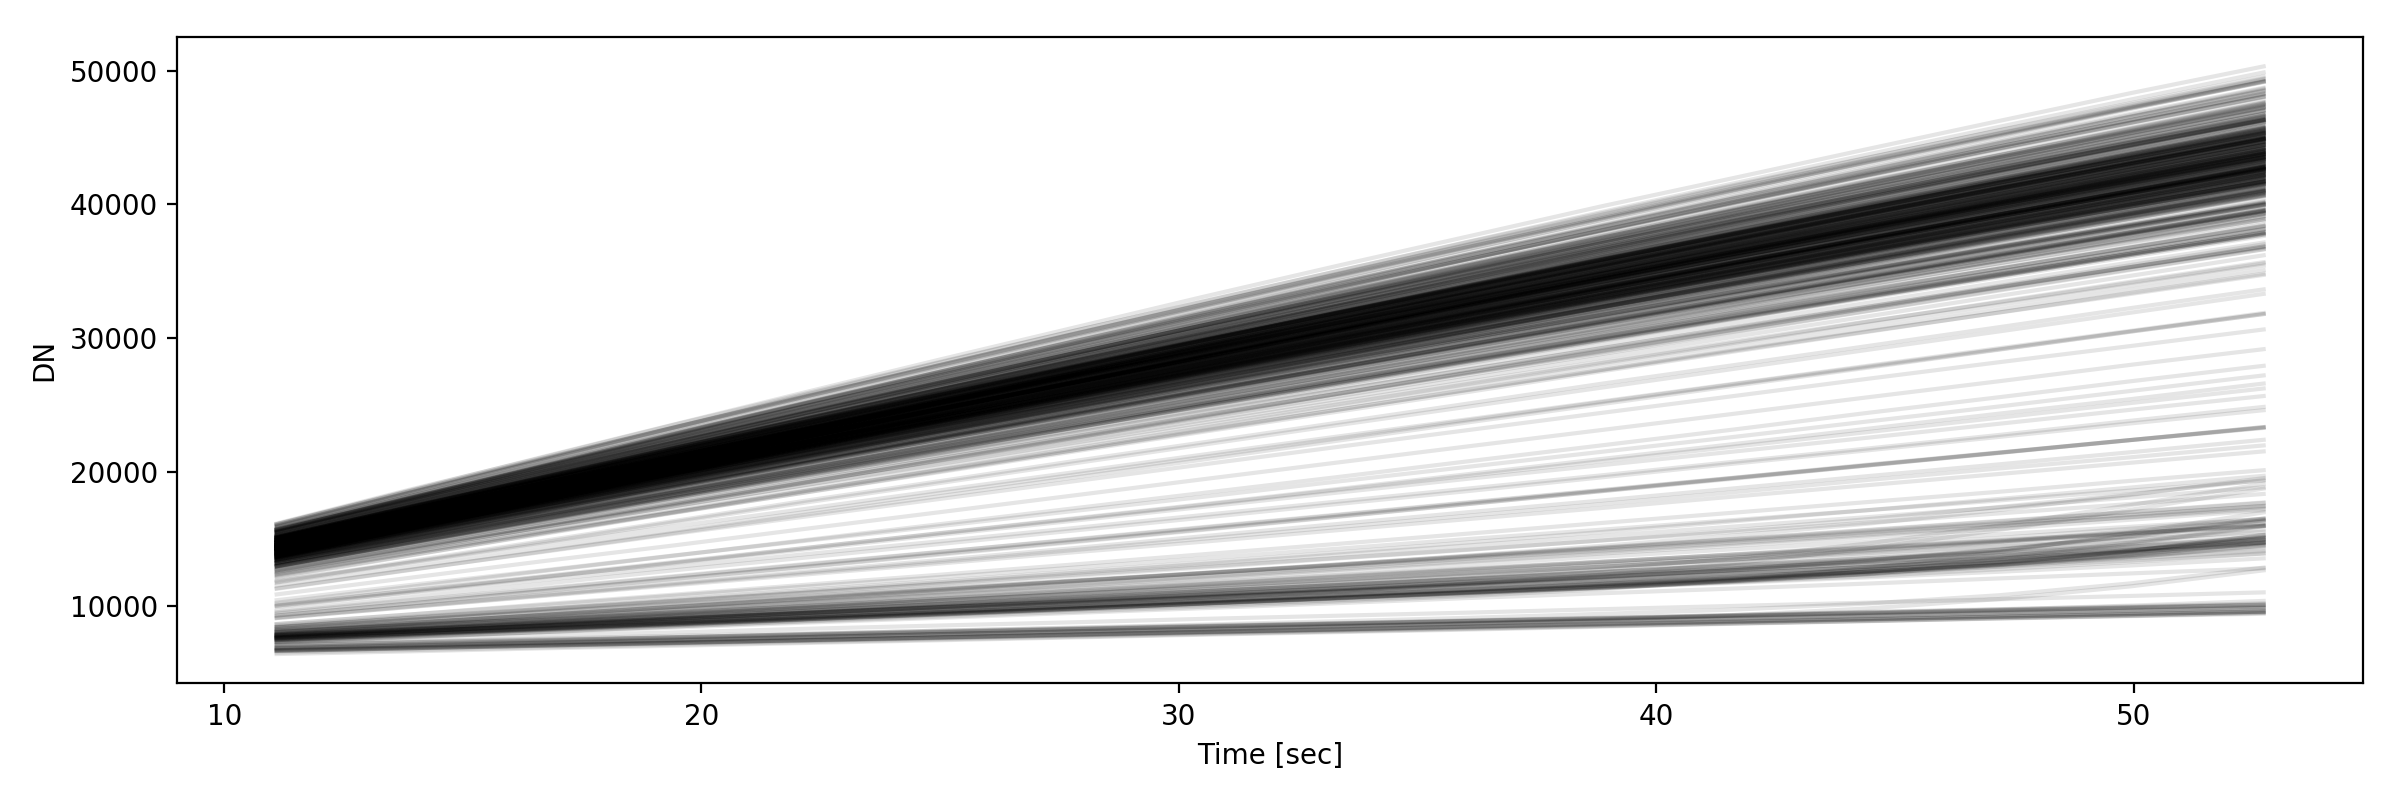

In [60]:
plt.close('all')

if band[0] in ['1','4']:
    range_x = range(10,512)
elif band[0] in ['2','3']:
    range_x = range(512,1020)

plt.figure(figsize=(12,4))
for ypos in [10]:
    for xpos in range_x:
        time  = np.arange(1,nframes+1)[(analyze_ramp-1)*ngroups:analyze_ramp*ngroups]*frame_delta_time
        tramp = image_data[(analyze_ramp-1)*ngroups:analyze_ramp*ngroups,ypos,xpos]
        time2,tramp2 = time[skip_first:-skip_last],tramp[skip_first:-skip_last]
        time3,tramp3 = time2[tramp2 < 58000],tramp2[tramp2 < 58000]
        plt.plot(time3,tramp3,'k',alpha=0.1)
plt.xlabel('Time [sec]')
plt.ylabel('DN')
plt.tight_layout()

In [61]:
plt.close('all')

## Derive non-linearity correction for a single pixel

<IPython.core.display.Javascript object>


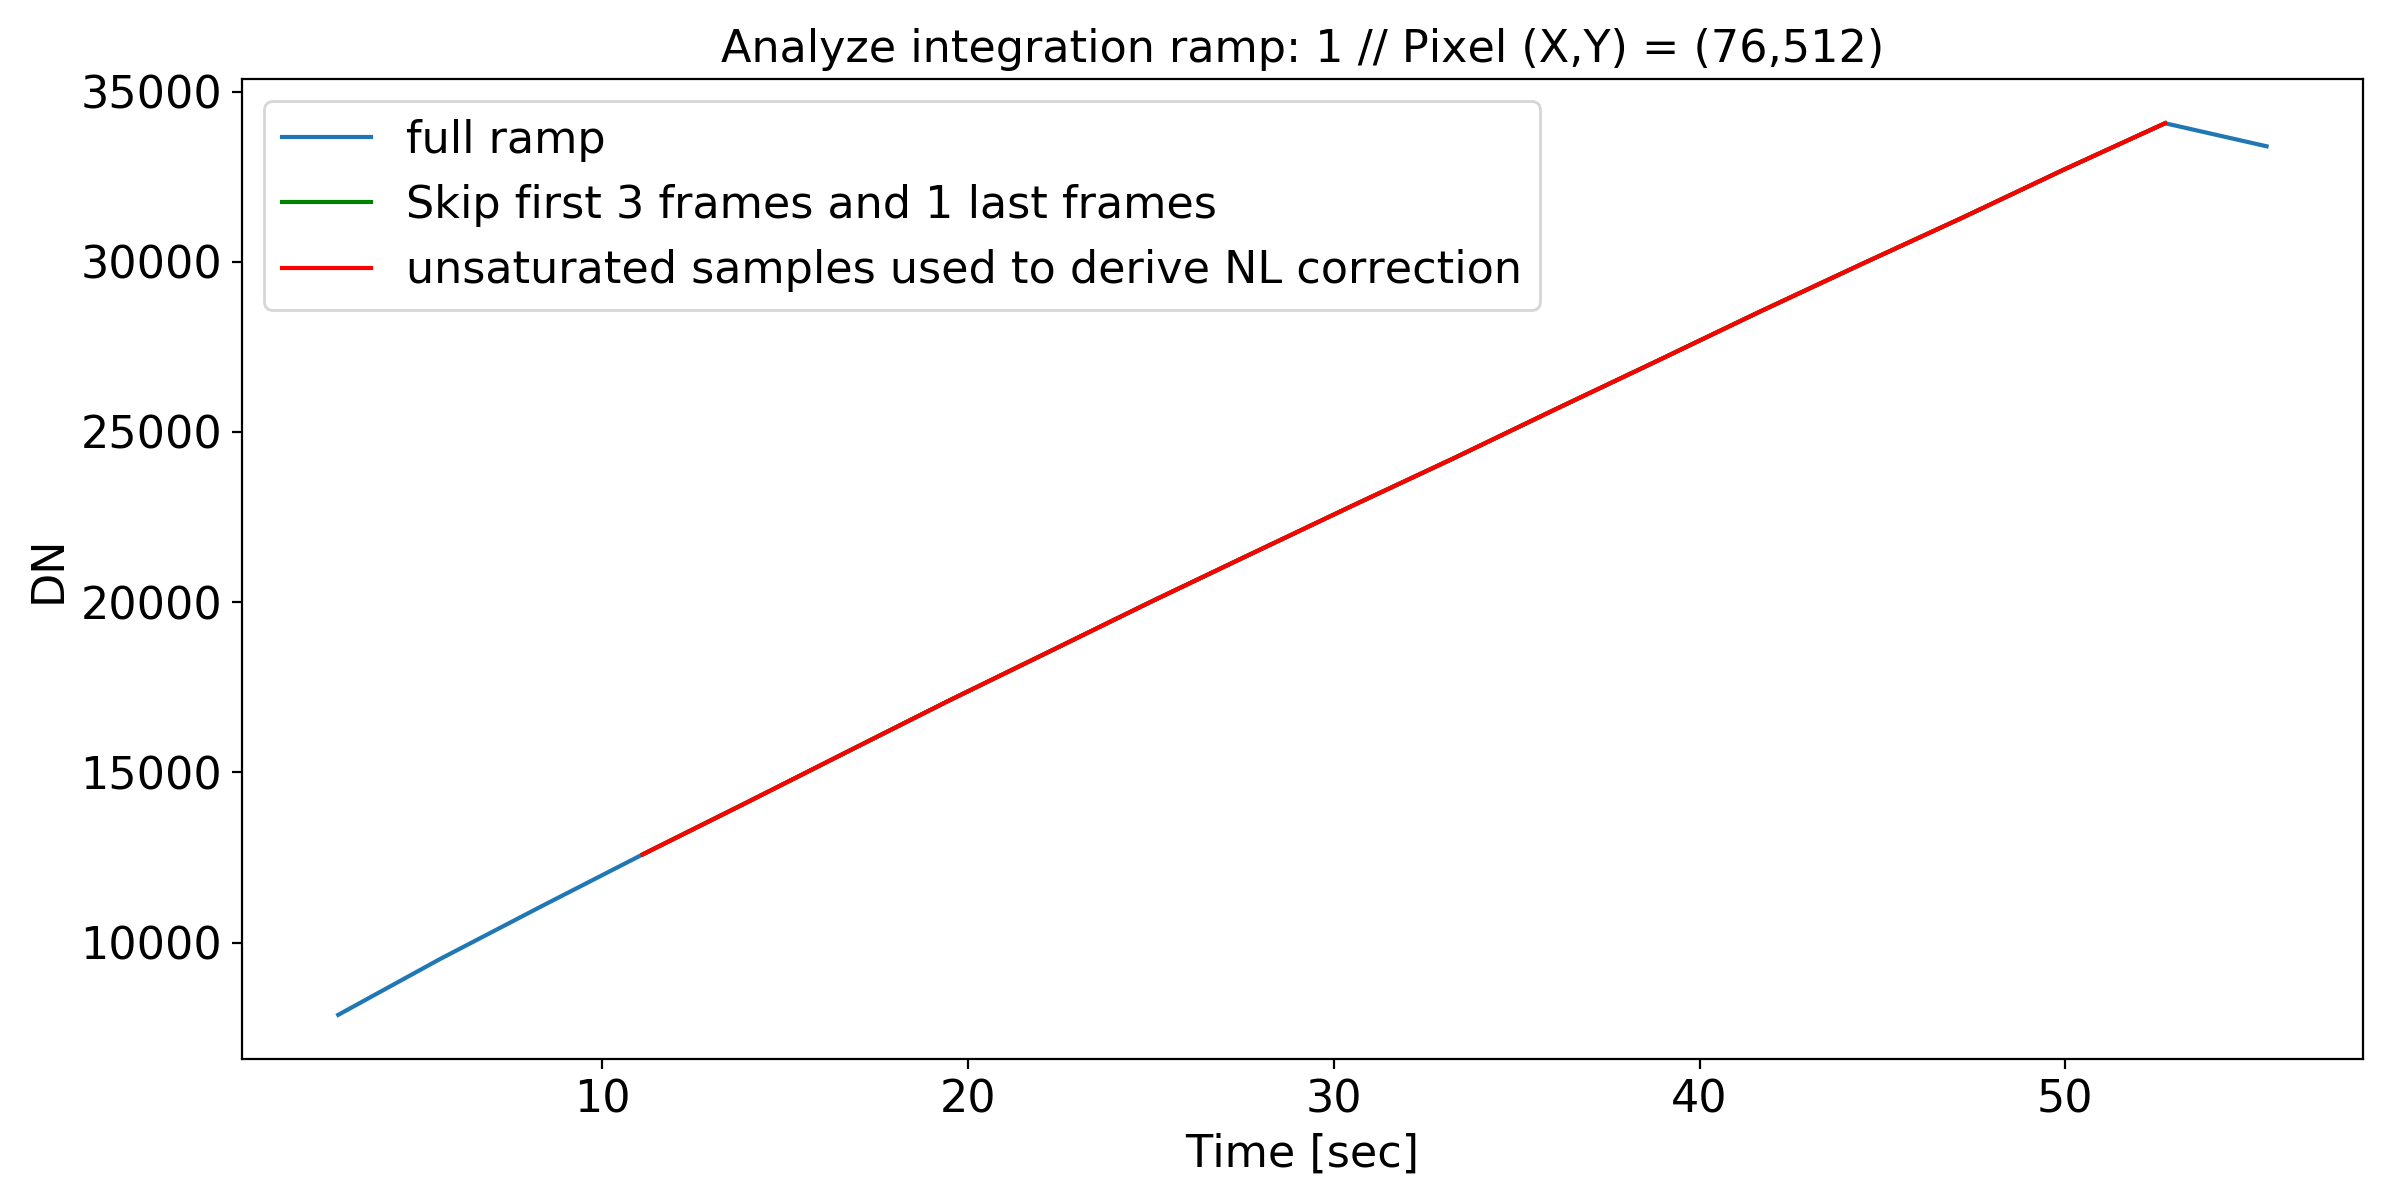

In [66]:
# Define ramp to be used for derivation of non-linearity correction
trace_y,trace_x = funcs.detpixel_trace(band,d2cMaps,sliceID=d2cMaps['nslices']/2,alpha_pos=0.)

row = 512
ypos,xpos = trace_y[row],trace_x[row]

time  = np.arange(1,nframes+1)[(analyze_ramp-1)*ngroups:analyze_ramp*ngroups]*frame_delta_time
tramp = image_data[(analyze_ramp-1)*ngroups:analyze_ramp*ngroups,ypos,xpos]
time2,tramp2 = time[skip_first:-skip_last],tramp[skip_first:-skip_last]
time3,tramp3 = time2[tramp2 < 58000],tramp2[tramp2 < 58000]

intime,inramp = time3,tramp3

plt.figure(figsize=(12,6))
plt.plot(time,tramp,label='full ramp')
plt.plot(time2,tramp2,'g',label='Skip first {} frames and {} last frames'.format(skip_first,skip_last))
plt.plot(time3,tramp3,'r',label='unsaturated samples used to derive NL correction')
plt.xlabel('Time [sec]',fontsize=16)
plt.ylabel('DN',fontsize=16)
plt.legend(fontsize=16)
plt.title('Analyze integration ramp: {} // Pixel (X,Y) = ({},{})'.format(analyze_ramp,xpos,ypos),fontsize=16)
plt.tick_params(axis='both',labelsize=16)
plt.tight_layout()

In [67]:
# define placeholders
out_ramp = np.zeros_like(inramp, dtype=np.float64)
new_rate = np.zeros(shape=(len(inramp)-1, image_shape[1], image_shape[2]), dtype=np.float64)

print('Output ramp (object shape): {}'.format(out_ramp.shape))
print('New rate (object shape): {}'.format(new_rate.shape))

Output ramp (object shape): (16,)
New rate (object shape): (15, 1024, 1032)


<IPython.core.display.Javascript object>


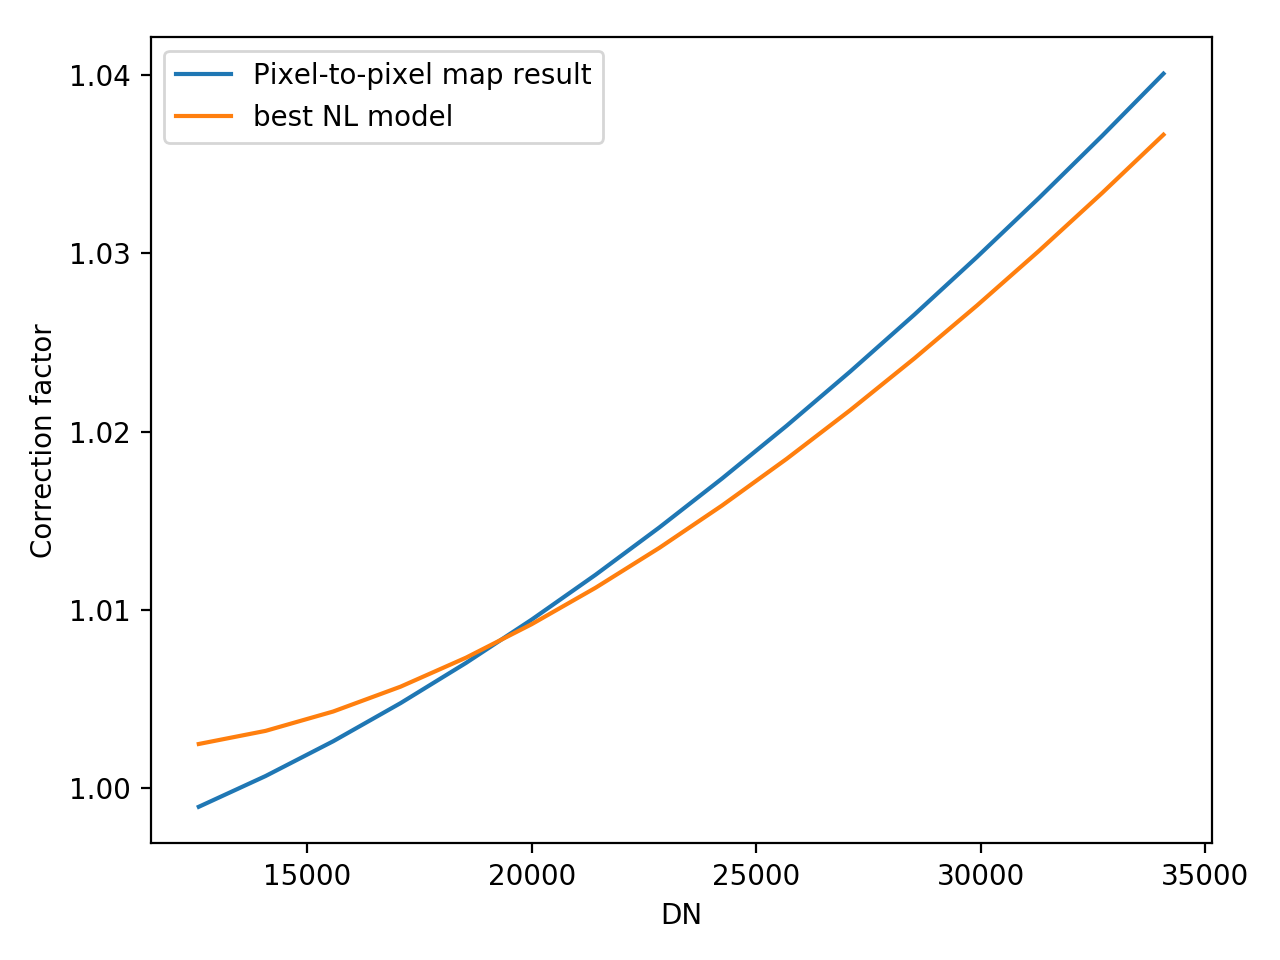

<IPython.core.display.Javascript object>


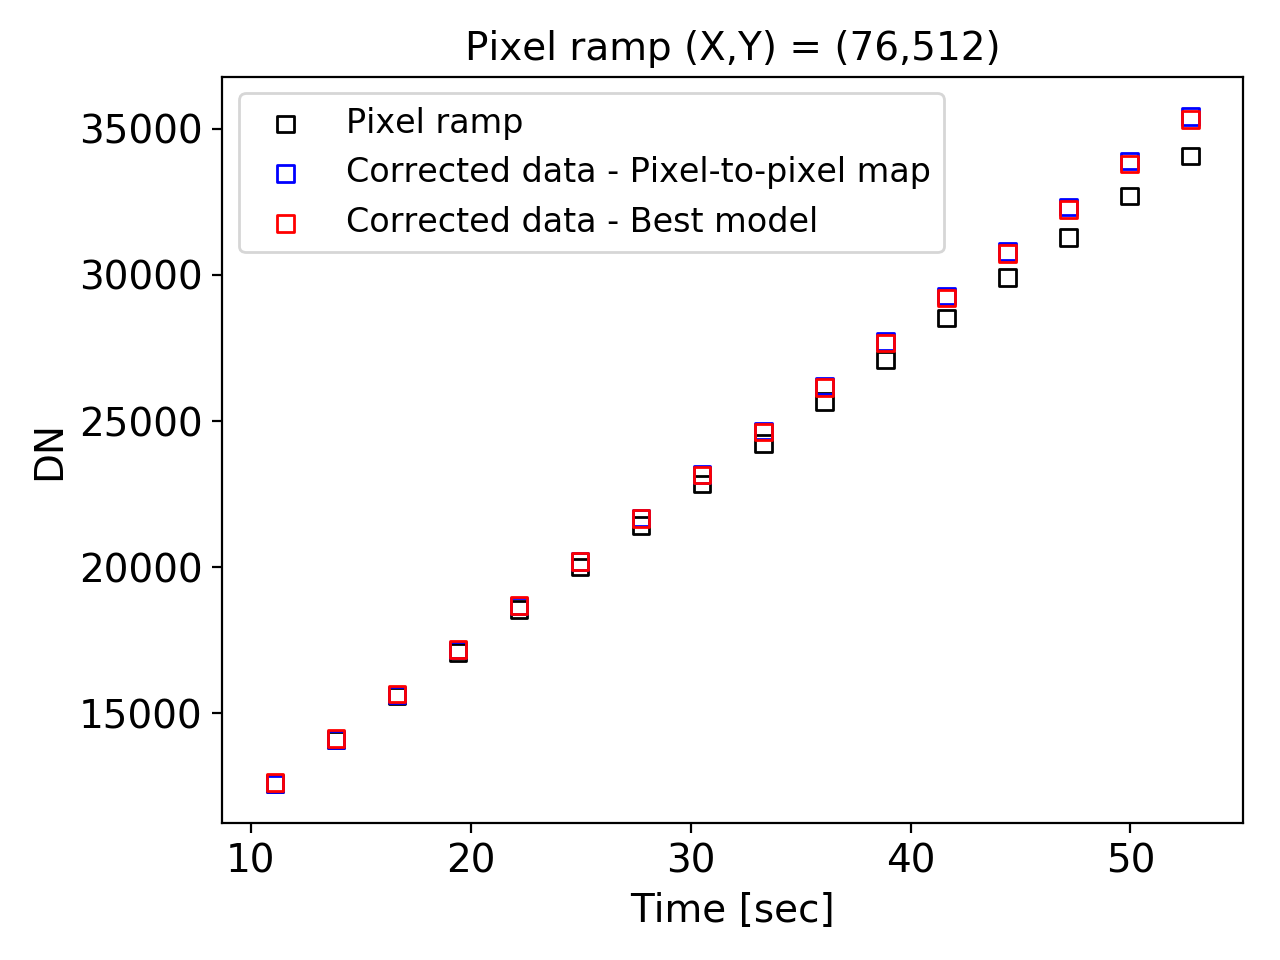

<IPython.core.display.Javascript object>


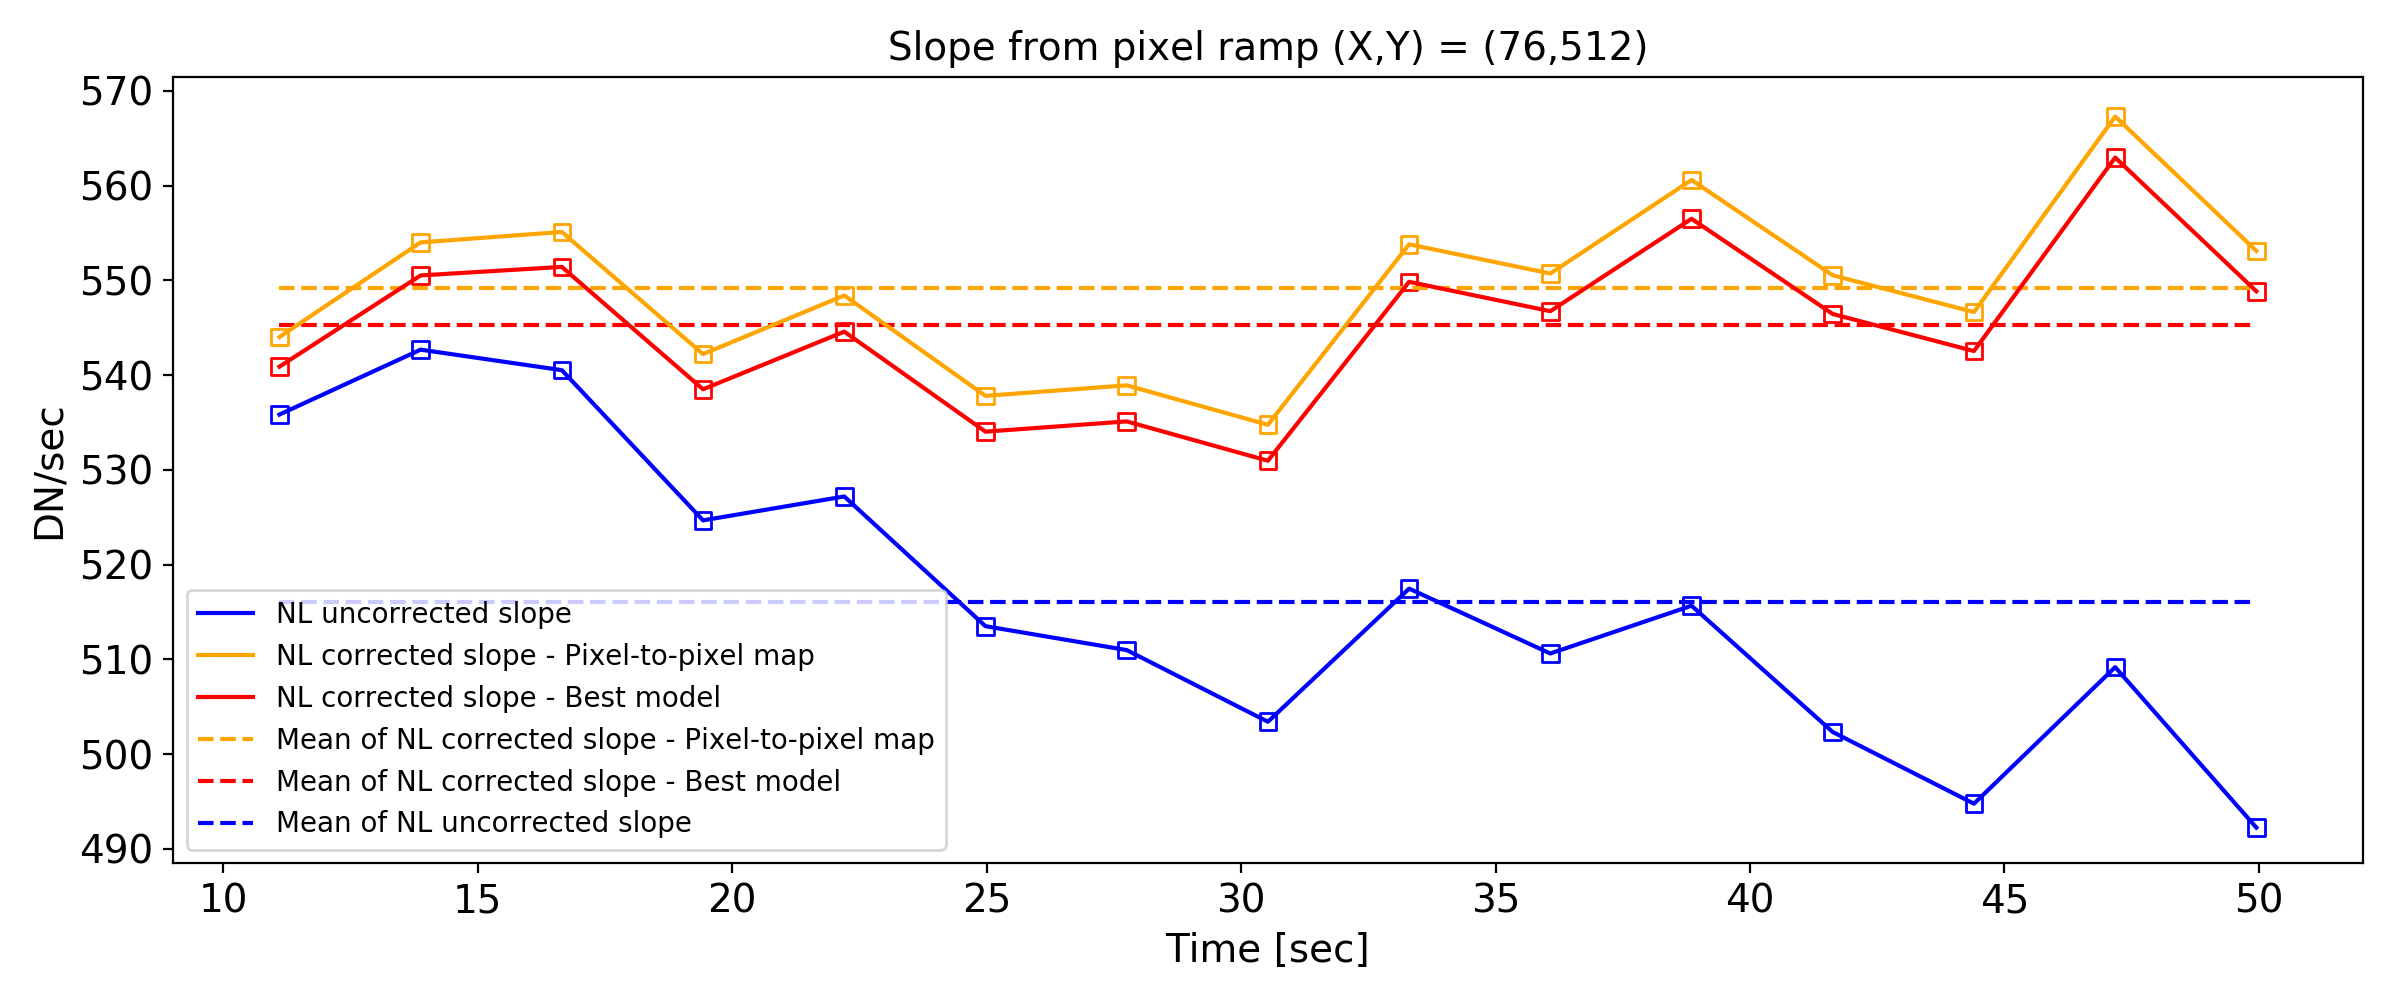

Pixel-dependent mean slope: 549.20776793 DN/sec
NL best model mean slope: 545.337743394 DN/sec


In [68]:
cor_factor_PixelToPixelMap = np.polynomial.polynomial.polyval(inramp, nl_coefficients_PixelToPixelMap[:, ypos, xpos])
cor_factor_BestModel = np.polynomial.polynomial.polyval(inramp, nl_coefficients_BestModel[:, ypos, xpos])

plt.figure()
plt.plot(inramp,cor_factor_PixelToPixelMap,label='Pixel-to-pixel map result')
plt.plot(inramp,cor_factor_BestModel,label='best NL model')
plt.xlabel('DN')
plt.ylabel('Correction factor')
plt.legend()
plt.tight_layout()

# correct ramp by applying derived NL correction
corrected_ramp_PixelToPixelMap = cor_factor_PixelToPixelMap * inramp
corrected_ramp_BestModel = cor_factor_BestModel * inramp

time_array = np.arange(skip_first+len(inramp)+skip_last+1)*frame_delta_time
plt.figure()
plt.scatter(intime,inramp,marker='s',facecolors='none',edgecolors='k',label='Pixel ramp')
plt.scatter(intime,corrected_ramp_PixelToPixelMap,marker='s',facecolors='none',edgecolors='b',label='Corrected data - Pixel-to-pixel map')
plt.scatter(intime,corrected_ramp_BestModel,marker='s',facecolors='none',edgecolors='r',label='Corrected data - Best model')
plt.xlabel('Time [sec]',fontsize=14)
plt.ylabel('DN',fontsize=14)
plt.legend(fontsize=12)
plt.title('Pixel ramp (X,Y) = ({},{})'.format(xpos,ypos),fontsize=14)
plt.tick_params(axis='both',labelsize=14)
plt.tight_layout()

new_rate_DN = np.diff(corrected_ramp_PixelToPixelMap)
new_rate[:, ypos, xpos] = new_rate_DN

plt.figure(figsize=(12,5))
plt.scatter(intime[:-1],np.diff(inramp)/frame_delta_time,marker='s',facecolors='none',edgecolors='b')
plt.plot(intime[:-1],np.diff(inramp)/frame_delta_time,'b',label='NL uncorrected slope')

plt.scatter(intime[:-1],np.diff(corrected_ramp_PixelToPixelMap)/frame_delta_time,marker='s',facecolors='none',edgecolors='orange')
plt.plot(intime[:-1],np.diff(corrected_ramp_PixelToPixelMap)/frame_delta_time,'orange',label='NL corrected slope - Pixel-to-pixel map')
plt.hlines(np.mean(np.diff(corrected_ramp_PixelToPixelMap)/frame_delta_time),intime[:-1][0],intime[:-1][-1],'orange',linestyle='dashed',label='Mean of NL corrected slope - Pixel-to-pixel map')

plt.scatter(intime[:-1],np.diff(corrected_ramp_BestModel)/frame_delta_time,marker='s',facecolors='none',edgecolors='r')
plt.plot(intime[:-1],np.diff(corrected_ramp_BestModel)/frame_delta_time,'r',label='NL corrected slope - Best model')
plt.hlines(np.mean(np.diff(corrected_ramp_BestModel)/frame_delta_time),intime[:-1][0],intime[:-1][-1],'r',linestyle='dashed',label='Mean of NL corrected slope - Best model')
plt.hlines(np.mean(np.diff(inramp)/frame_delta_time),intime[:-1][0],intime[:-1][-1],'b',linestyle='dashed',label='Mean of NL uncorrected slope')
plt.xlabel('Time [sec]',fontsize=14)
plt.ylabel('DN/sec',fontsize=14)
plt.title('Slope from pixel ramp (X,Y) = ({},{})'.format(xpos,ypos),fontsize=14)
plt.legend(fontsize=10)
plt.tick_params(axis='both',labelsize=14)
plt.tight_layout()

print 'Pixel-dependent mean slope: {} DN/sec'.format(np.mean(new_rate_DN/frame_delta_time))
print 'NL best model mean slope: {} DN/sec'.format(np.mean(np.diff(corrected_ramp_BestModel)/frame_delta_time))

Linear fit coefficients - Pixel To Pixel Correction: [6.73727549e+02 6.60793056e-02]
Linear fit coefficients - Best Model Correction: [6.91197659e+02 1.89145452e-01]


<IPython.core.display.Javascript object>


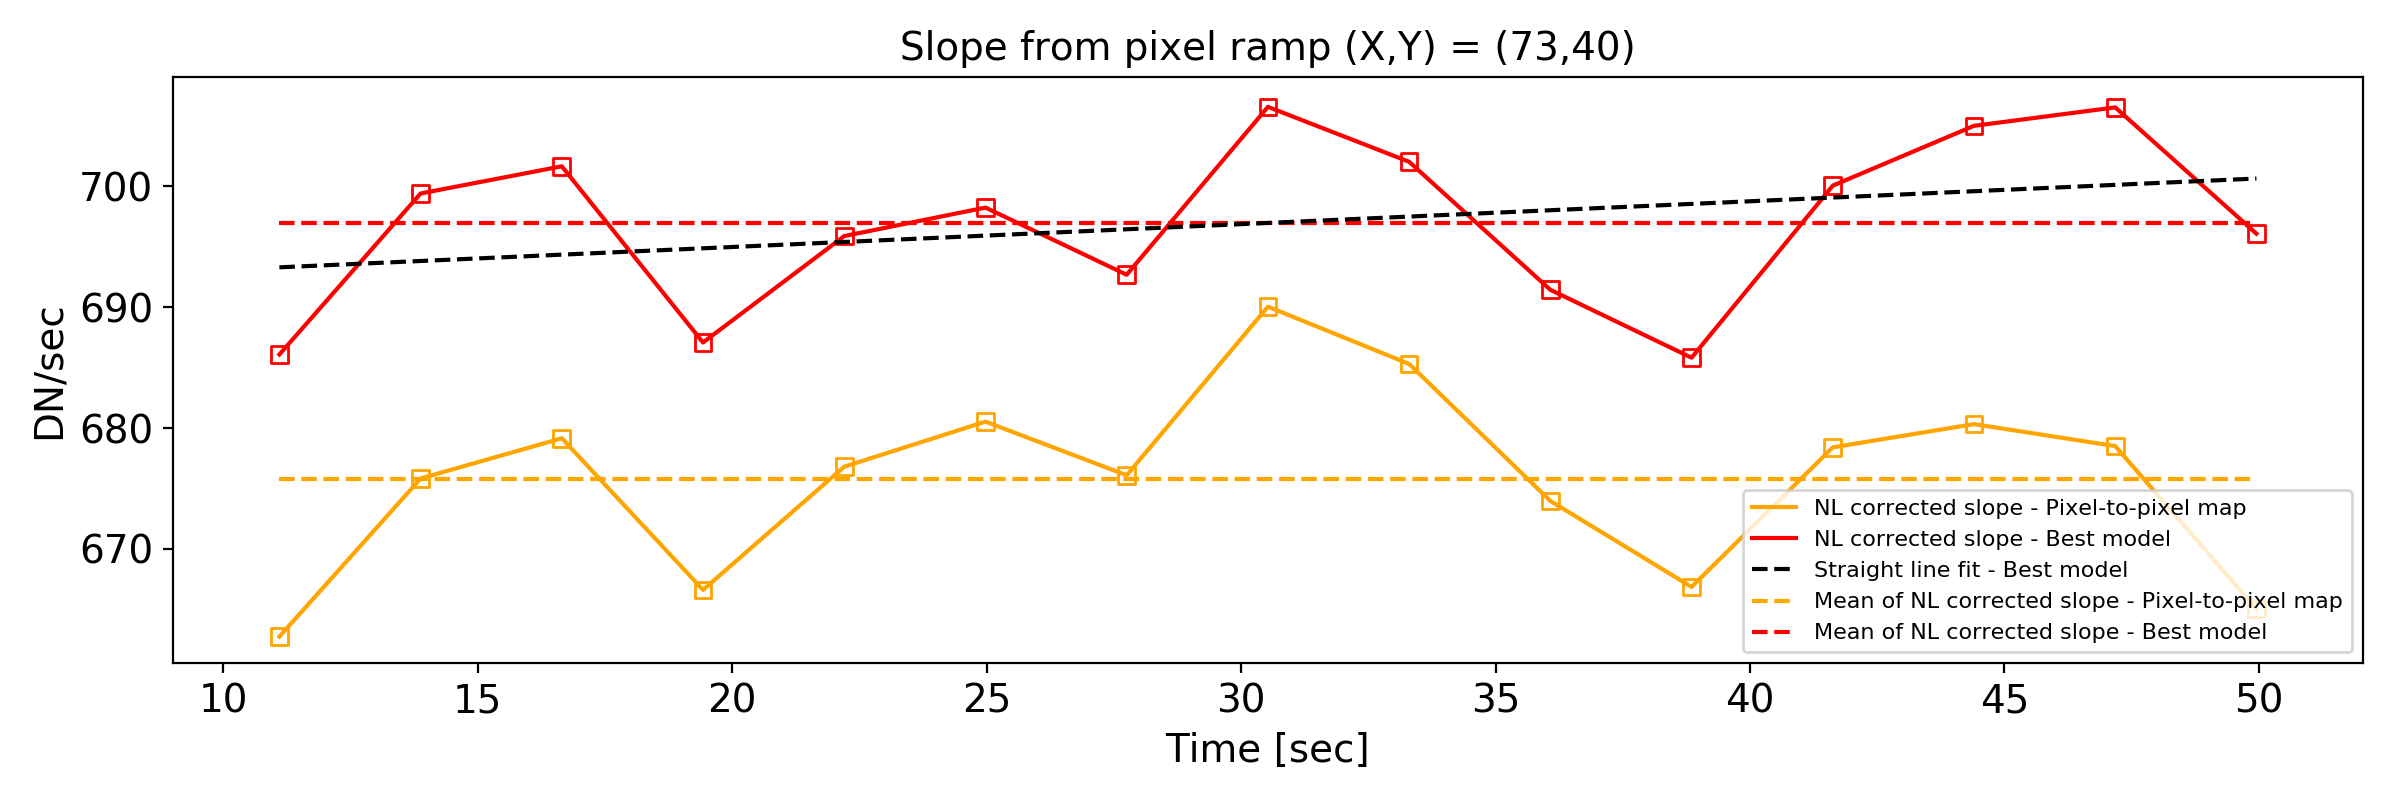

In [65]:
#solve for the correction factor as a function of observed DN.
coefs_PixelToPixelMapCorrection = np.polynomial.polynomial.polyfit(intime[:-1], np.diff(corrected_ramp_PixelToPixelMap)/frame_delta_time, 1)
poly_PixelToPixelMapCorrection = np.poly1d(coefs_PixelToPixelMapCorrection[::-1])

print 'Linear fit coefficients - Pixel To Pixel Correction: {}'.format(coefs_PixelToPixelMapCorrection)

coefs_BestModelCorrection = np.polynomial.polynomial.polyfit(intime[:-1], np.diff(corrected_ramp_BestModel)/frame_delta_time, 1)
poly_BestModelCorrection = np.poly1d(coefs_BestModelCorrection[::-1])

print 'Linear fit coefficients - Best Model Correction: {}'.format(coefs_BestModelCorrection)

plt.figure(figsize=(12,4))
plt.scatter(intime[:-1],np.diff(corrected_ramp_PixelToPixelMap)/frame_delta_time,marker='s',facecolors='none',edgecolors='orange')
plt.plot(intime[:-1],np.diff(corrected_ramp_PixelToPixelMap)/frame_delta_time,'orange',label='NL corrected slope - Pixel-to-pixel map')
plt.hlines(np.mean(np.diff(corrected_ramp_PixelToPixelMap)/frame_delta_time),intime[:-1][0],intime[:-1][-1],'orange',linestyle='dashed',label='Mean of NL corrected slope - Pixel-to-pixel map')

plt.scatter(intime[:-1],np.diff(corrected_ramp_BestModel)/frame_delta_time,marker='s',facecolors='none',edgecolors='r')
plt.plot(intime[:-1],np.diff(corrected_ramp_BestModel)/frame_delta_time,'r',label='NL corrected slope - Best model')
plt.hlines(np.mean(np.diff(corrected_ramp_BestModel)/frame_delta_time),intime[:-1][0],intime[:-1][-1],'r',linestyle='dashed',label='Mean of NL corrected slope - Best model')
plt.plot(intime[:-1],poly_BestModelCorrection(intime[:-1]),'k',linestyle='dashed',label='Straight line fit - Best model')

plt.xlabel('Time [sec]',fontsize=14)
plt.ylabel('DN/sec',fontsize=14)
plt.title('Slope from pixel ramp (X,Y) = ({},{})'.format(xpos,ypos),fontsize=14)
plt.legend(fontsize=8)
plt.tick_params(axis='both',labelsize=14)
plt.tight_layout()

## Derive non-linearity corrected relevant parameters for a single trace in MRS slice

In [69]:
# initialize placeholders
gradient = np.zeros(shape =(image_shape[1], image_shape[2] ), dtype=np.float64)
slope_at_time0 = np.zeros(shape =(image_shape[1], image_shape[2] ), dtype=np.float64)
slope_BestModel = np.zeros(shape =(image_shape[1], image_shape[2] ), dtype=np.float64)
slope_pixelTopixelCorr = np.zeros(shape =(image_shape[1], image_shape[2] ), dtype=np.float64)

d2cMaps = funcs.load_obj('d2cMaps_band{}_tr90pc'.format(band),path=d2cMapDir)
trace_y,trace_x = funcs.detpixel_trace(band,d2cMaps,sliceID=d2cMaps['nslices']/2,alpha_pos=0.)
for i in range(1024):
    if i%100 == 0:
        print 'Row {}'.format(i)
    ypos,xpos = trace_y[i],trace_x[i]
    time  = np.arange(1,nframes+1)[(analyze_ramp-1)*ngroups:analyze_ramp*ngroups]*frame_delta_time
    tramp = image_data[(analyze_ramp-1)*ngroups:analyze_ramp*ngroups,ypos,xpos]
    time2,tramp2 = time[skip_first:-skip_last],tramp[skip_first:-skip_last]
    time3,tramp3 = time2[tramp2 < 58000],tramp2[tramp2 < 58000]

    # derive non-linearity correction
    intime = time3
    inramp = tramp3
    
    #solve for the correction factor as a function of observed DN.
    cor_factor_PixelToPixelMap = np.polynomial.polynomial.polyval(inramp, nl_coefficients_PixelToPixelMap[:, ypos, xpos])
    cor_factor_BestModel = np.polynomial.polynomial.polyval(inramp, nl_coefficients_BestModel[:, ypos, xpos])
    
    # correct ramp by applying derived NL correction
    corrected_ramp_PixelToPixelMap = cor_factor_PixelToPixelMap * inramp
    corrected_ramp_BestModel = cor_factor_BestModel * inramp
    
    # 
    coefs_BestModelCorrection = np.polynomial.polynomial.polyfit(intime[:-1], np.diff(corrected_ramp_BestModel)/frame_delta_time, 1)
    
    # insert results in placeholder array
    gradient[ypos,xpos] = coefs_BestModelCorrection[1]
    slope_at_time0[ypos,xpos] = coefs_BestModelCorrection[0]
    slope_BestModel[ypos,xpos] = np.mean(np.diff(corrected_ramp_BestModel)/frame_delta_time)
    slope_pixelTopixelCorr[ypos,xpos] = np.mean(np.diff(corrected_ramp_PixelToPixelMap)/frame_delta_time)

Row 0
Row 100
Row 200
Row 300
Row 400
Row 500
Row 600
Row 700
Row 800
Row 900
Row 1000


<IPython.core.display.Javascript object>


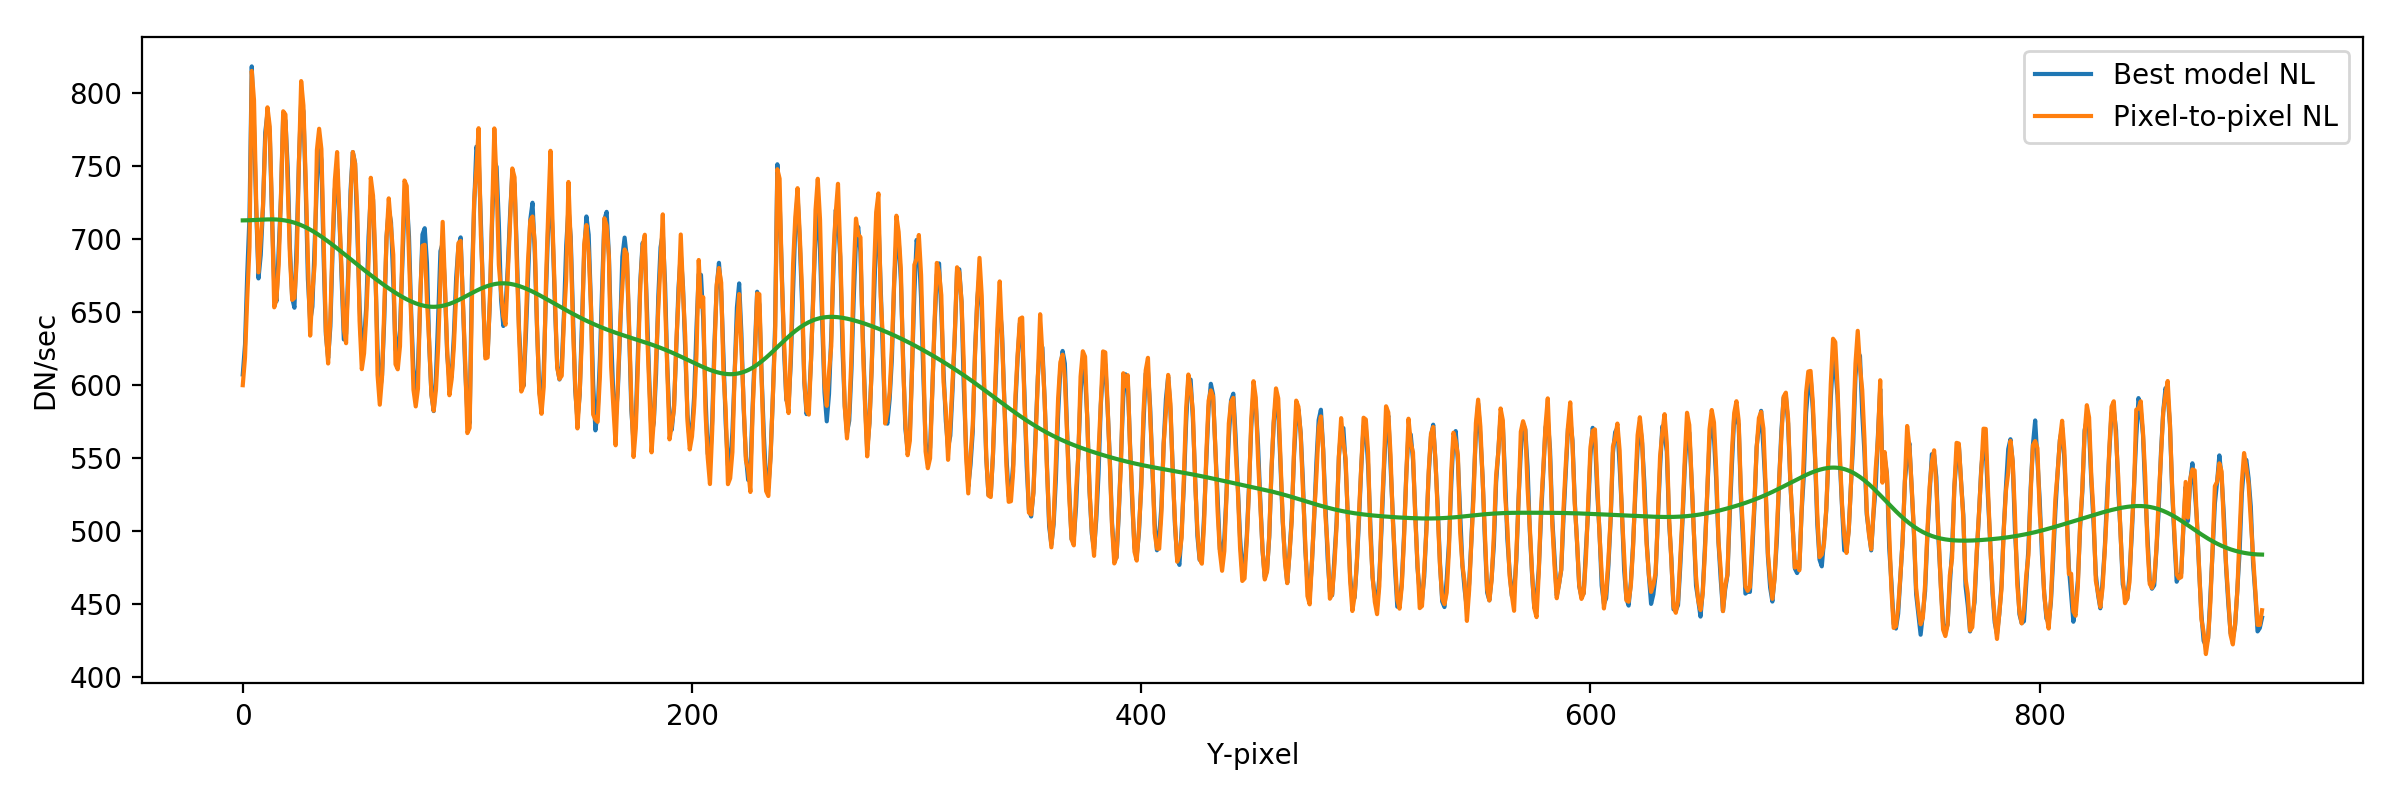

In [70]:
plt.close('all')

d2cMaps = funcs.load_obj('d2cMaps_band{}_tr90pc'.format(band),path=d2cMapDir)
trace_y,trace_x = funcs.detpixel_trace(band,d2cMaps,sliceID=d2cMaps['nslices']/2,alpha_pos=0.)
trace_y,trace_x = trace_y[50:950],trace_x[50:950]

sigma_smooth = 15
plt.figure(figsize=(12,4))
plt.plot(slope_BestModel[trace_y,trace_x],label='Best model NL')
plt.plot(slope_pixelTopixelCorr[trace_y,trace_x],label='Pixel-to-pixel NL')
plt.plot(gaussian_filter1d(slope_pixelTopixelCorr[trace_y,trace_x],sigma_smooth))
plt.xlabel('Y-pixel')
plt.ylabel('DN/sec')
plt.legend()
plt.tight_layout()
